<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

# Land Cover Classification - Part 2

Author michele.claus@eurac.edu

Date: 2023/09/12

In this notebook we will create a new dataset with Synthetic Aperture Radar (SAR) data from Sentinel-1.

It will be pre-processed using the Eurac's openEO back-end.

## Connect and login

In [1]:
import openeo
openeoHost = "openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


## SAR processing

We load an openEO collection containing pre-processed Sentinel-1 SLC data. It contains real and imaginary parts of each polarization, the longitude and latitude grids used for geocoding, LIA and DEM used for radar masking.

In [2]:
conn.describe_collection("SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL")

{'stac_version': '0.9.0',
 'stac_extensions': ['datacube'],
 'type': 'Collection',
 'id': 'SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL',
 'title': 'SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL',
 'description': 'Sentinel-1 SLC Data. SAR2Cube Level-0 preprocessing.',
 'deprecated': False,
 'license': 'CC-BY-4.0',
 'providers': [{'name': 'Eurac EO ODC',
   'url': 'http://www.eurac.edu/',
   'roles': ['producer', 'host']}],
 'extent': {'spatial': {'bbox': [[9.528703689575195,
     45.31370162963867,
     13.141668319702148,
     47.318817138671875]]},
  'temporal': {'interval': [['2016-09-08T05:27:59Z',
     '2022-08-20T05:27:59Z']]}},
 'links': [{'rel': 'license',
   'href': 'https://creativecommons.org/licenses/by/4.0/',
   'type': 'text/html',
   'title': 'License link'}],
 'cube:dimensions': {'DATE': {'type': 'temporal',
   'extent': ['2016-09-08T05:27:59+00:00', '2022-08-20T05:27:59+00:00']},
  'X': {'type': 'spatial',
   'axis': 'x',
   'extent': [9.528703689575195, 13.141668319702148],
   'reference_system': 32632},
  'Y': {'type': 'spatial',
   'axis': 'y',
   'extent': [45.31370162963867, 47.318817138671875],
   'reference_system': 32632},
  'bands': {'type': 'bands',
   'values': ['DEM',
    'LIA',
    'i_VH',
    'i_VV',
    'q_VH',
    'q_VV',
    'grid_lat',
    'grid_lon',
    'i_ifg_VH',
    'i_ifg_VV',
    'q_ifg_VH',
    'q_ifg_VV',
    'i_ifg_VH_nocorrect',
    'i_ifg_VV_nocorrect',
    'q_ifg_VH_nocorrect',
    'q_ifg_VV_nocorrect']}}}

## Load the datacube

In [3]:
collection      = "SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL"
temporal_extent = ["2022-06-01T00:00:00.000Z", "2022-08-30T00:00:00.000Z"]
spatial_extent = {"west": 11.158992052767568,
                  "east": 11.490353569352353,
                  "south": 46.3861302250657,
                  "north": 46.57346510967079
                 }

S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent)

Compute the intensity

In [4]:
i_VV = S1_slant_range.band("i_VV")
q_VV = S1_slant_range.band("q_VV")
S1_INT_VV = i_VV**2+q_VV**2
S1_INT_VV = S1_INT_VV.add_dimension(name="bands",label="VV")

i_VH = S1_slant_range.band("i_VH")
q_VH = S1_slant_range.band("q_VH")
S1_INT_VH = i_VH**2+q_VH**2
S1_INT_VH = S1_INT_VH.add_dimension(name="bands",label="VH")

S1_INT = S1_INT_VV.merge_cubes(S1_INT_VH)

Compute the Multi Look over the intensity.

In [5]:
range_looks   = 4
azimuth_looks = 19

S1_INT_ML = S1_INT.aggregate_spatial_window(
    size=[azimuth_looks,range_looks],
    reducer="mean")

Linear to dB conversion:

In [6]:
from openeo.processes import log
S1_INT_ML = S1_INT_ML.apply(lambda x: 10*log(x,base=10))

Compute the same Multi Look over the coordinate grids for geocoding

In [7]:
lat_lon_grids = S1_slant_range.filter_bands(["grid_lon","grid_lat"])

lat_lon_grids_ML = lat_lon_grids.aggregate_spatial_window(
    size=[azimuth_looks,range_looks],
    reducer="mean")

Merge the intensity and the coordinate grids into the same datacube

In [8]:
S1_INT_ML = S1_INT_ML.merge_cubes(lat_lon_grids_ML)

Compute the monthly aggregation over time

In [9]:
S1_INT_ML_AGG = S1_INT_ML.aggregate_temporal_period(period="month",reducer="mean")

Apply geocoding. We choose 20m resolution for the pixel size and the local UTM zone as projection.

We can choose only from 10, 20 or 60m for resolution, for being able to align the data with Sentinel-2 grid.

This process is not yet an official openEO process and therefore the syntax to apply it is not streamlined as with the other processes.

In [10]:
args_geocoding = {"resolution":10,"crs":32632}
S1_INT_ML_AGG_GEOCODED = S1_INT_ML_AGG.process("geocode",args_geocoding, data=S1_INT_ML_AGG)

In [11]:
S1_INT_ML_AGG_GEOCODED_NC = S1_INT_ML_AGG_GEOCODED.save_result(format="netCDF")

In [12]:
job = conn.create_job(S1_INT_ML_AGG_GEOCODED_NC,title="SAR2Cube_land_cover_dataset")
job_id = job.job_id
print('Batch job created with id: ',job_id)
job.start_job()

Batch job created with id:  f6d7cd15-5943-43ca-8885-2749866b8020


<BatchJob job_id='f6d7cd15-5943-43ca-8885-2749866b8020'>

In [14]:
job

<BatchJob job_id='f6d7cd15-5943-43ca-8885-2749866b8020'>

Download the result

In [15]:
import os
result_dir_name = "SAR2Cube_land_cover_dataset"
if not os.path.exists(result_dir_name):
    os.mkdir(result_dir_name)
result = job.get_results()
result.download_files(result_dir_name)

[WindowsPath('SAR2Cube_land_cover_dataset/result.nc'),
 WindowsPath('SAR2Cube_land_cover_dataset/process.json'),
 WindowsPath('SAR2Cube_land_cover_dataset/job-results.json')]

In [16]:
import xarray as xr
data = xr.open_dataarray(result_dir_name + "/result.nc",decode_coords="all").to_dataset(dim="variable")

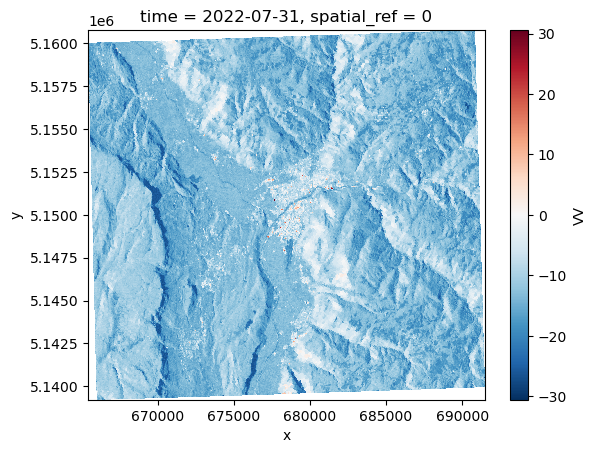

In [17]:
data.VV[1].plot.imshow()

Store the data in a new netCDF as an xArray Dataset (our openEO back-end stores it in xArray DataArray), which we will use for the advanced exercise for land cover classification

In [18]:
data.to_netcdf("sentinel_1_2022.nc")